# Importing Libraries and Loading data

Dataset for lab: https://drive.google.com/file/d/1QCSCGixrHN9PjPRsbpMd_0bruCwgPsGC/view?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
import os
import math
import cv2

import pickle

import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
from collections import Counter
import string
import os
import gensim
from spacy.matcher import PhraseMatcher
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from textblob import TextBlob, Word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

In [ ]:
df=pd.read_csv("lab_rnn_train.csv")

In [ ]:
df.head(10)

In [ ]:
df.shape

In [ ]:
df.target.unique()

# Cleaning data

In [ ]:
def clean_data(hd_df, col_name):

    # Converting to lower case
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Removing tags
    hd_df[col_name] = hd_df[col_name].str.replace('<.*?>','')

    # Removing possible mentions or urls
    hd_df[col_name] = hd_df[col_name].str.replace('@\w+','')
    hd_df[col_name] = hd_df[col_name].str.replace('http.?://[^\s]+[\s]?','')

    # Removing punctuation and symbols
    hd_df[col_name] = hd_df[col_name].str.replace('[^\w\s]', '')
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(y for y in x.split() if y not in string.punctuation))

    # Removing non alphabetical character
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(y for y in x.split() if y.isalpha()))

    # Removing characters non longer than 1
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(y for y in x.split() if len(y) > 1))

    # Removing stopwords
    sw = stopwords.words('english')
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(y for y in x.split() if y not in sw))

    # Removing digits
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join(y for y in x.split() if not y.isdigit()))

    # Removing multiple spaces
    hd_df[col_name] = hd_df[col_name].str.replace(' +',' ')

    # Lemmatization 
    hd_df[col_name] = hd_df[col_name].apply(lambda x: " ".join([Word(w).lemmatize() for w in x.split()]))

    return hd_df

The stemmed form of studies is: studi

The stemmed form of studying is: study

#############################################

The lemmatized form of studies is: study

The lemmatized form of studying is: study

In [ ]:
df_new = clean_data(df,'text')
df_new.head()

In [ ]:
#function to split text into word
tokens = word_tokenize(df_new.text.str.cat(sep=' '))
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
# sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
tweets = list()
lines  = df_new.text.values.tolist()
print(lines)

for i,line in enumerate(lines):
  tokens = word_tokenize(line)
  tokens = [w.lower() for w in tokens]
  table = str.maketrans('','',string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped  if word.isalpha()]
  tweets.append(words)

In [ ]:
print(len(tweets))
print(tweets[0])

# Preparing input

## Bag of Words (BOW): 
We make the list of unique words in the text corpus called vocabulary. Then we can represent each sentence or document as a vector with each word represented as 1 for present and 0 for absent from the vocabulary. 

1. We will study NNFL today
2. Our focus would be on text classification

We:1 

will:2 

study:3 

NNFL:4 

today:5 

our:6 

focus:7 

would:8 

be:9 

on:10 

text:11 

classification:12

BOW representation of We = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
BOW representation of Text = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

-> To represent a word in the above corpa, we will need a vector of length as total number of distinct words. Now, can we represent the word in another embedding space with less dimensions preserving language semantic information?


## TF-IDF:
Another representation can be count the number of times each word appears in a document. The most popular approach is using the Term Frequency-Inverse Document Frequency (TF-IDF) technique.

- Term Frequency (TF) = (Number of times term t appears in a document)/(Number of terms in the document)

- Inverse Document Frequency (IDF) = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in. The IDF of a rare word is high, whereas the IDF of a frequent word is likely to be low. Thus having the effect of highlighting words that are distinct.

- We calculate TF-IDF value of a term as = TF * IDF

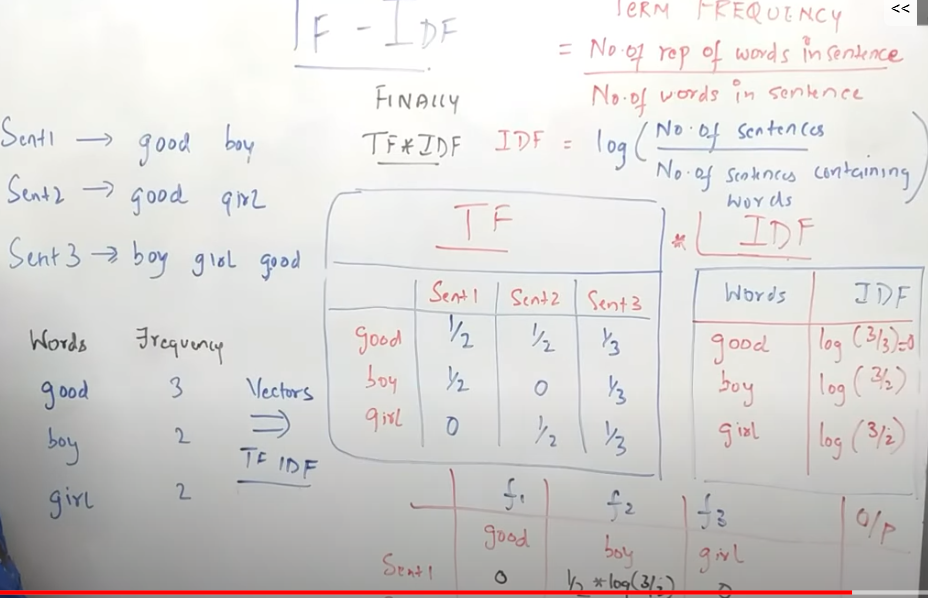

Source: https://www.youtube.com/watch?v=D2V1okCEsiE

One of the major disadvantages of using BOW is that it discards word order thereby ignoring the context and in turn meaning of words in the document. For natural language processing (NLP) maintaining the context of the words is of utmost importance. To solve this problem we use another approach called Word Embedding.

## Word Embeddings

Word Embedding is a representation of text where words that have the same meaning have a similar representation. In other words it represents words in a coordinate system where related words, based on a corpus of relationships, are placed closer together. In the deep learning frameworks such as TensorFlow, Keras, this part is usually handled by an embedding layer which stores a lookup table to map the words represented by numeric indexes to their dense vector representations.

## Learning word embeddings:

The word embeddings of our dataset can be learned while training a neural network on the classification problem. Before it can be presented to the network, the text data is first encoded so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API provided with Keras. We add padding to make all the vectors of same length (max_length). Below code converts the text to integer indexes, now ready to be used in Keras embedding layer.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


tokenizer_obj = Tokenizer()
max_length = max([ len(k) for s in tweets for k in s])

print("Max length is: "+ str(max_length))
tokenizer_obj.fit_on_texts(tweets)
sequences  = tokenizer_obj.texts_to_sequences(tweets)

word_index=tokenizer_obj.word_index
print(len(word_index))

from keras.preprocessing.sequence import pad_sequences 

review_pad = pad_sequences(sequences,maxlen=max_length)
sentiment = df['target'].values
print(review_pad.shape)
print(sentiment.shape)

print(tweets[0])
print(sequences[0])
print(review_pad[0])

indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]

In [ ]:
EMBEDDING_DIM = 100
num_words = len(word_index) + 1

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,SpatialDropout1D,GRU, RNN
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.initializers import Constant

In [ ]:
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=max_length))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

The embedding param count 10270900 = (vocab_size * EMBEDDING_DIM). 

In [ ]:
history = model.fit(x=review_pad, y=sentiment, epochs=3, batch_size=512, validation_split = 0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

## Word2Vec

Ref: https://www.youtube.com/watch?v=UqRCEmrv1gQ

In [ ]:
import gensim
model=gensim.models.Word2Vec(sentences=tweets,size=EMBEDDING_DIM,window=5,workers=4,min_count=1)

words=list(model.wv.vocab)
print(len(words))

- i. sentences – List of sentences; here we pass the list of review sentences.
- ii. size – The number of dimensions in which we wish to represent our word. This is the size of the word vector.
- iii. min_count – Word with frequency greater than min_count only are going to be included into the model. Usually, the bigger and more extensive your text, the higher this number can be.
- iv. window – Only terms that occur within a window-neighborhood of a term, in a sentence, are associated with it during training. The usual value is 4 or 5.
- v. workers– Number of threads used in training parallelization, to speed up training

In [ ]:
model.wv.most_similar('horrible')

In [ ]:
filename = 'word2vec_tweets.txt'
model.wv.save_word2vec_format(filename,binary=False)

In [ ]:
embeddings_index={}
f=open(os.path.join('','word2vec_tweets.txt'),encoding="utf-8")
print(f)

In [ ]:
for line in f:
    print(line)
    values=line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

Now we will map embeddings from the loaded word2vec model for each word to the tokenizer_obj.word_index vocabulary and create a matrix with of word vectors.

In [ ]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

In [ ]:
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,SpatialDropout1D,GRU, SimpleRNN
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.initializers import Constant

In [ ]:
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), input_length=max_length, trainable=False))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(review_pad, sentiment, epochs=10, batch_size=4096,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
plt.show();

In [ ]:
# Save weights
model.save_weights("model.h5")

# HOMEWORK:

1. Experiment with GLoVE / Any other Embedding instead of Word2Vec and print reported score. 

    Ref Link: https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8e

    https://medium.com/the-innovation/sentiment-analysis-using-word2vec-and-glove-embeddings-5ad7d50ddb0d

2. Experiment with data cleaning, network architecture and hyperparamaters for at-least 5 runs and report all the obtained scores along with their hyperparameters. (Put some effort into this) For each experiment, along with accuracy, also report precision, recall, F1 score and confusion matrix.

Other refs:
https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958

 https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

In [ ]:
# Complete HW here

In [ ]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import string
from textblob import Word
import nltk
nltk.download('wordnet')
import gensim
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,GRU, RNN, Conv1D, MaxPool1D, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.initializers import Constant
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv("lab_rnn_train.csv")
print('Shape of dataset is', df.shape)

In [ ]:
df.head(5)

In [ ]:
array = df.text.to_numpy()
cleaned_list = []
table = str.maketrans('','',string.punctuation)
max_len = 0
for line in array:
    new_line = line.translate(table)
    new_line = new_line.lower()
    tokens = new_line.split()
    tokens =  [Word(word).lemmatize() for word in tokens]
    final_tokens = [word for word in tokens if word.isalpha()]
    max_len = max(max_len, len(final_tokens))
    cleaned_list.append(final_tokens)

In [ ]:
print(max_len)
print(len(cleaned_list))
print(cleaned_list[0:10])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_list)
sequences = tokenizer.texts_to_sequences(cleaned_list)
word_index = tokenizer.word_index
final_sequences = pad_sequences(sequences, maxlen=max_len, padding ='post', truncating='post')
print(cleaned_list[0])
print(sequences[0])
print(final_sequences[0])

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Glove embedding: https://www.kaggle.com/danielwillgeorge/glove6b100dtxt

In [ ]:
EMBD = 100
model = gensim.models.Word2Vec(cleaned_list,size=EMBD, window=10, workers=4,min_count=1)
words = list(model.wv.vocab)

In [ ]:
assert (len(word_index) ==  len(words))
model.wv.save_word2vec_format("embedding")
embedding_matrix = np.zeros((len(word_index)+1, EMBD))

In [ ]:
file1 = "/content/drive/My Drive/glove.6B.100d.txt"
file2 = "embedding"
f = open(file2)
sequence_meanings = {}
word_meanings ={}
extra_embeddings = []
for line in f:
    values=line.split()
    word = values[0]
    meaning = np.asarray(values[1:])
    try:
        index = word_index[word]
        word_meanings[word] = meaning
    except KeyError as K:
        pass
f.close()

In [ ]:
embedding_matrix = np.zeros((len(word_index)+1, EMBD))
for word, index in word_index.items():
    if word in word_meanings:
        embedding_matrix[index] = word_meanings[word]
print(embedding_matrix.shape)

In [ ]:
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], EMBD, embeddings_initializer=Constant(embedding_matrix), input_length=max_len, trainable=False))
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(final_sequences, df['target'].values, shuffle=True, random_state=42, test_size =0.30)

In [ ]:
optimizer = Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=30, batch_size=16384,  validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_title('Loss')
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='val')
axs[1].set_ylabel('acc')
axs[1].set_xlabel('epoch')
axs[1].legend()

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
y_pred_final = [1 if y>0.5 else 0 for y in y_pred]

In [ ]:
report = classification_report(y_test, y_pred_final, output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(3)
my_df

In [ ]:
pd.DataFrame(confusion_matrix(y_test, y_pred_final))
# True label is the i-th class and predicted label being j-th class